In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import nltk
from nltk.corpus import wordnet, cmudict, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')

from textblob import TextBlob
from gensim.models import LsiModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from collections import Counter
import textstat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv("/home/eetil1818/code/nghia95/fake-data-detector/raw_data/1k_sampled_dataset.csv")
data.head()

,text,source,prompt_id,text_length,word_count
0,The Philosophy and Ethics of Transhumanism\n\n...,GPT-3.5,1920,2558,394
1,Crime-tracking app Citizen is launching its ow...,Flan-T5-XXL,0,378,62
2,The court in Novorossiysk gave two of the danc...,GLM-130B,0,621,109
3,"then drops the drumsticks, poses, then walks o...",GPT-J,0,513,90
4,On tally went to the beach. She found a sand d...,GPT-J,0,4984,846


# Data Exploration

In [3]:
df = data.copy()
df["source"] = df["source"].apply(lambda x: "AI" if x != "Human" else x)
df.drop(columns="prompt_id", inplace=True)
df.head()

,text,source,text_length,word_count
0,The Philosophy and Ethics of Transhumanism\n\n...,AI,2558,394
1,Crime-tracking app Citizen is launching its ow...,AI,378,62
2,The court in Novorossiysk gave two of the danc...,AI,621,109
3,"then drops the drumsticks, poses, then walks o...",AI,513,90
4,On tally went to the beach. She found a sand d...,AI,4984,846


In [4]:
df["source"].value_counts(normalize=True)

source
Human    0.559
AI       0.441
Name: proportion, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1000 non-null   object
 1   source       1000 non-null   object
 2   text_length  1000 non-null   int64 
 3   word_count   1000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


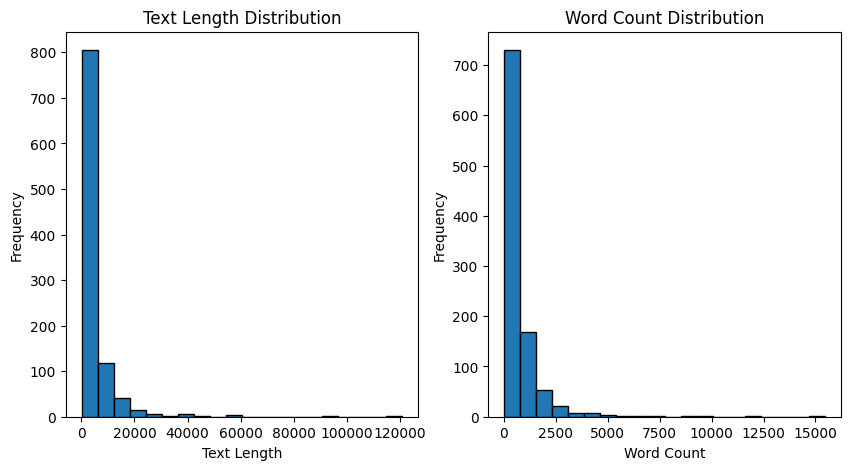

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(df["text_length"], bins=20, edgecolor="black")
axes[0].set_title("Text Length Distribution")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")

axes[1].hist(df["word_count"], bins=20, edgecolor="black")
axes[1].set_title("Word Count Distribution")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")

plt.show()


In [7]:
# Check if text column contains numbers and special characters

df["contains_numbers"] = df["text"].str.contains(r"\d", regex=True)
df["contains_special_chars"] = df["text"].str.contains(r"[^\w\s]", regex=True)

df.head()

,text,source,text_length,word_count,contains_numbers,contains_special_chars
0,The Philosophy and Ethics of Transhumanism\n\n...,AI,2558,394,False,True
1,Crime-tracking app Citizen is launching its ow...,AI,378,62,True,True
2,The court in Novorossiysk gave two of the danc...,AI,621,109,True,True
3,"then drops the drumsticks, poses, then walks o...",AI,513,90,True,True
4,On tally went to the beach. She found a sand d...,AI,4984,846,False,True


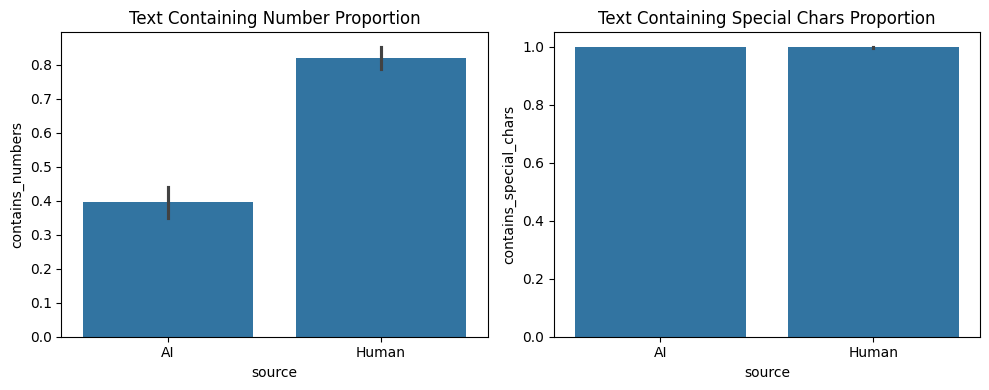

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=df["source"], y=df["contains_numbers"], ax=axes[0])
axes[0].set_title("Text Containing Number Proportion")

sns.barplot(x=df["source"], y=df["contains_special_chars"], ax=axes[1])
axes[1].set_title("Text Containing Special Chars Proportion")

plt.tight_layout();

In [9]:
df["contains_numbers"].value_counts()

contains_numbers
True     634
False    366
Name: count, dtype: int64

In [10]:
df["contains_special_chars"].value_counts()

contains_special_chars
True     999
False      1
Name: count, dtype: int64

In [11]:
# checking one of the text that contains special chars

df[df["contains_special_chars"] == True]["text"].iloc[4]

'On tally went to the beach. She found a sand dollar along the shore. She didn\'t know what to do with it. She asked people along the beach if they knew how she could get rid of her pain, but everyone had an idea except for one man who stood onshore and said that he knew nothing about such things. She was worried because every day her mother remained in bed longer than usual. The days were hot now so long as her mother remained indoors. Her friend\'s father took her home just before noon when his shift ended at two o\'clock. At nightfall while waiting for him to return from work, Anna fell asleep across doorsills where cooks walked up and down bringing food or going out looking for something else to eat. Her mother moaned all through their walk back to Mijas until they reached the house. This time nobody came and no-one opened the door. Silence reigned inside too. "I\'m getting cold," her mother kept repeating. "You\'ll have to keep me warm." In vain did she try to lift herself off the

# Data Cleaning

In [ ]:
symbols_to_keep = {"$", "-", "%"}

def text_cleaning(text):
    """Clean text but preserve some symbols and numbers."""
    text = text.lower() # Turn to all lowercase
    text = text.strip() # Remove whitespace
    text = " ".join(text.split()) # Remove multiple spaces

    text_clean = []

    for char in text:
        if char not in string.punctuation or char in symbols_to_keep:
            text_clean.append(char)  # Keep numbers and allowed symbols
        else:
            text_clean.append("")  # Replace other punctuation with space/nothing

    text_clean = "".join(text_clean)

    tokenized = word_tokenize(text_clean)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    cleaned_text = " ".join(lemmatized)

    return cleaned_text


In [13]:
df_clean = df.drop(columns=["contains_numbers", "contains_special_chars"])
df_clean.head()

,text,source,text_length,word_count
0,The Philosophy and Ethics of Transhumanism\n\n...,AI,2558,394
1,Crime-tracking app Citizen is launching its ow...,AI,378,62
2,The court in Novorossiysk gave two of the danc...,AI,621,109
3,"then drops the drumsticks, poses, then walks o...",AI,513,90
4,On tally went to the beach. She found a sand d...,AI,4984,846


In [84]:
df_clean["clean_text"] = df_clean["text"].apply(text_cleaning)

# Add new columns to label, calculate char and words in the cleaned_text
df_clean["label"] = df_clean["source"].apply(lambda x: 1 if x == "AI" else 0) #AI=1, Human=0
df_clean["clean_text_len"] = df_clean["clean_text"].str.len()
df_clean["clean_word_count"] = df_clean["clean_text"].str.split().apply(len)

In [15]:
df_clean.head(3)

,text,source,text_length,word_count,clean_text,label,clean_text_len,clean_word_count
0,The Philosophy and Ethics of Transhumanism\n\n...,AI,2558,394,the philosophy and ethic of transhumanism tran...,1,2462,394
1,Crime-tracking app Citizen is launching its ow...,AI,378,62,crime-tracking app citizen is launching it own...,1,363,62
2,The court in Novorossiysk gave two of the danc...,AI,621,109,the court in novorossiysk gave two of the danc...,1,594,109


# Feature Extraction - Copying Romaric's features

In [16]:
# Consonnant Density
def cons_density(text):
    consonant = sum(1 for char in text if char.isalpha() and char not in "aeiouAEIOU")
    vowel = sum(1 for char in text if char.isalpha() and char in "aeiouAEIOU")
    return round((consonant/(vowel + consonant)),3)


In [17]:
# Stress Pattern
#nltk.download("cmudict")
cmu_dict = cmudict.dict()

def get_word_stress(word):
    if word in cmu_dict:
        return sum(int(char) for syllable in cmu_dict[word][0] for char in syllable if char.isdigit())
    return 0

def get_sentence_stress(sentence):
    words = sentence.split()
    stress_values = [get_word_stress(word) for word in words]
    return sum(stress_values)

In [18]:
# Repetition and Redundancy

def redundance(text):
    # give a redundance score, considering the lenght of each text, if a lemmatized words appears more than three times the mean, it is considered redundant.

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    clean_tokens = [w for w in tokens if w not in stop_words]

    lemmatizer = WordNetLemmatizer()
    verb_lemmas = {word: lemmatizer.lemmatize(word, pos='v') for word in clean_tokens}

    final_lemmas = [lemmatizer.lemmatize(lemma, pos='n') if lemma == word else lemma
                    for word, lemma in verb_lemmas.items()]

    word_counts = Counter(final_lemmas)
    mean_freq = sum(word_counts.values()) / len(word_counts)

    score = sum(1 for word, count in word_counts.items() if count > 3 * mean_freq)

    return score

In [19]:
# Emotion and personality

def sentiment_polarity(text):
    sent_pol = TextBlob(text).sentiment.polarity
    return abs(round(sent_pol,3))

In [20]:
# Unusual word choice

def word_choice(text):
    common_ai_words =["commendable",'transhumanist', 'meticulous', 'elevate','hello', 'tapestry' 'leverage',
                  'journey', 'headache','resonate','testament','explore', 'binary','delve',
                  'enrich', 'seamless','multifaceted', 'sorry','foster', 'convey', 'beacon',
                  'interplay', 'oh', 'navigate','form','adhere','cannot', 'landscape','remember',
                  'paramount', 'comprehensive', 'placeholder','grammar','real','summary','symphony',
                  'furthermore','relationship','ultimately','profound','art','supercharge','evolve',
                  'beyoud','reimagine','vibrant', 'robust','pivotal','certainly','quinoa','orchestrate','align',
                  'diverse','recommend','annals','note','employ','bustling','indeed','digital','enigma', 'outfit',
                  'indelible','refrain','culture','treat','emerge','meticulous','esteemed','weight','whimsical','bespoke',
                  'highlight','antagonist','unlock','key','breakdown','tailor','misinformation','treasure','paradigm','captivate',
                  'song','underscore','calculate','especially','climate','hedging','inclusive','exercise','ai','embrace',
                  'level','nuance','career','dynamic','accent','ethos','cheap','firstly','online','goodbye'
                  ]
    word_count = 0
    for word in text.split():
        if word in common_ai_words:
            word_count += 1
        else: pass

    return word_count

In [21]:
# Context and coherence

def coherence(text):
    # uses gensim to measure coherence, use the lsi model(latent semantic indexing, coherence c_v because we provide the text and n_topic = 5)
    tokens = word_tokenize(text)
    dictionary = corpora.Dictionary([tokens])
    corpus_gensim = [dictionary.doc2bow(tokens)]
    lsa_model = LsiModel(corpus_gensim, id2word=dictionary)

    coherence_model = CoherenceModel(
        model=lsa_model,
        texts=[tokens],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [22]:
# Readability

def reading_ease(text):
    reading_ease= textstat.flesch_reading_ease(text)
    return reading_ease


def gunning_fog(text):
    gunning_fog = textstat.gunning_fog(text)
    return gunning_fog

In [86]:
df_features = df_clean.copy()
df_features.drop(columns=["text", "source", "text_length", "word_count", "clean_text_len", "clean_word_count"], inplace=True)

# Only use 500 rows for faster processing
df_features500 = df_features.sample(500, random_state=42)
df_features500.head()

,clean_text,label
521,the jewish state the struggle for israel ’ s s...,0
737,turn on her side and then lay down on the floo...,1
740,alphabetical order is not the optimal layout b...,1
660,we propose a two-layer cache mechanism to spee...,1
411,jane austen novel have stood the test of time ...,1


In [88]:
df_features500["cons_density"] = df_features500["clean_text"].apply(cons_density)
df_features500["stress_value2"] = df_features500["clean_text"].apply(get_sentence_stress)/len(df_features500["clean_text"])
df_features500["token_redundance"] = df_features500["clean_text"].apply(redundance)
df_features500["sentiment_score"] = df_features500["clean_text"].apply(sentiment_polarity)
df_features500["unusual_word_count"] = df_features500["clean_text"].apply(word_choice)
df_features500["coherence_score"] = df_features500["clean_text"].apply(coherence)

df_features500.head()

,clean_text,label,cons_density,stress_value2,token_redundance,sentiment_score,unusual_word_count,coherence_score
521,the jewish state the struggle for israel ’ s s...,0,0.609,3.272,0,0.076,10,0.251326
737,turn on her side and then lay down on the floo...,1,0.616,0.190,0,0.006,0,0.852354
740,alphabetical order is not the optimal layout b...,1,0.591,0.132,0,0.358,2,1.000000
660,we propose a two-layer cache mechanism to spee...,1,0.614,0.122,0,0.227,1,1.000000
411,jane austen novel have stood the test of time ...,1,0.596,1.468,0,0.154,13,0.187560


# Preprocessing Pre-Trained Models:
✅ DistilBERT (TF Hub) – Good trade-off between accuracy & memory.

✅ ALBERT (TF Hub) – Lighter version than BERT.

### Input requirements:

input_word_ids → Tokenized words

input_mask → Indicates which tokens are real vs. padding

#input_type_ids → Used for sentence pairs in BERT

In [25]:
#!pip install tensorflow==2.15 keras tensorflow-hub tensorflow-text

In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

2025-02-14 16:44:44.488950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-14 16:44:44.489108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-14 16:44:44.947297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 16:44:52.525451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [27]:
# Load models & preprocessing from TensorFlow Hub

distilbert_model = hub.load("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2")
distilbert_preprocess = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") # Tokenize to meet input requirements

albert_model = hub.load("https://tfhub.dev/google/albert_base/3")
albert_preprocess = hub.load("https://tfhub.dev/tensorflow/albert_en_preprocess/3") # Tokenize to meet input requirements

In [41]:
def get_embeddings(texts, model, preprocess_model, batch_size=32):
    """Generate embeddings after preprocessing"""
    preprocessed_text = preprocess_model(texts)
    inputs = {
        "input_word_ids": preprocessed_text["input_word_ids"],
        "input_mask": preprocessed_text["input_mask"],
        "input_type_ids": preprocessed_text["input_type_ids"],  # Needed even if all zeros
    }

    return np.array(model(inputs)["pooled_output"])

In [89]:
# Get embeddings on a sample of the 1k data

texts = df_features500["clean_text"].tolist()

distilbert_embeddings = get_embeddings(texts, distilbert_model, distilbert_preprocess)
albert_embeddings = get_embeddings(texts, distilbert_model, distilbert_preprocess)

distilbert_embeddings.shape, albert_embeddings.shape

((500, 512), (500, 512))

In [117]:
distilbert_df.shape, df_features500.shape

((500, 512), (500, 8))

In [118]:
# Merge BERT embeddings with features in a dataframe

distilbert_df = pd.DataFrame(distilbert_embeddings).reset_index(drop=True)
df_features500 = df_features500.reset_index(drop=True)
distilbert_final_df = pd.concat([df_features500, distilbert_df], axis=1)

distilbert_final_df.head(2)

,clean_text,label,cons_density,stress_value2,token_redundance,sentiment_score,unusual_word_count,coherence_score,0,1,...,502,503,504,505,506,507,508,509,510,511
0,the jewish state the struggle for israel ’ s s...,0,0.609,3.272,0,0.076,10,0.251326,-0.22732,0.871502,...,0.159982,0.266400,0.581010,-0.936296,0.591772,0.991633,0.503393,0.026867,-0.507095,-0.507787
1,turn on her side and then lay down on the floo...,1,0.616,0.190,0,0.006,0,0.852354,0.85951,0.478003,...,0.041755,-0.097893,0.065251,-0.693617,0.401227,0.752702,-0.175724,0.230093,-0.278581,-0.147343


In [119]:
# Merge ALBERT embeddings with features in a dataframe

albert_df = pd.DataFrame(albert_embeddings).reset_index(drop=True)
df_features500 = df_features500.reset_index(drop=True)
albert_final_df = pd.concat([df_features500, albert_df], axis=1)

albert_final_df.head(2)

,clean_text,label,cons_density,stress_value2,token_redundance,sentiment_score,unusual_word_count,coherence_score,0,1,...,502,503,504,505,506,507,508,509,510,511
0,the jewish state the struggle for israel ’ s s...,0,0.609,3.272,0,0.076,10,0.251326,-0.22732,0.871502,...,0.159982,0.266400,0.581010,-0.936296,0.591772,0.991633,0.503393,0.026867,-0.507095,-0.507787
1,turn on her side and then lay down on the floo...,1,0.616,0.190,0,0.006,0,0.852354,0.85951,0.478003,...,0.041755,-0.097893,0.065251,-0.693617,0.401227,0.752702,-0.175724,0.230093,-0.278581,-0.147343


# Model Training & Evaluation

In [120]:
# Split data for training

# DISTILBERT
X_distilbert = distilbert_final_df.drop(columns=["clean_text", "label"])  # Keep only features
y_distilbert = distilbert_final_df["label"]  # Target column (AI vs. Human)

X_train_distilbert, X_test_distilbert, y_train_distilbert, y_test_distilbert = train_test_split(
  X_distilbert, y_distilbert, test_size=0.2, random_state=42)

# ALBERT
X_albert = albert_final_df.drop(columns=["clean_text", "label"])
y_albert = albert_final_df["label"]

X_train_albert, X_test_albert, y_train_albert, y_test_albert = train_test_split(
  X_albert, y_albert, test_size=0.2, random_state=42)

In [123]:
# Model training

from tensorflow import keras
from tensorflow.keras import layers, models, metrics

def nn_model(input_shape):
    """Create a simple neural network model."""
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),  # Input layer
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # Binary classification (AI vs. Human)
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            metrics.Precision(name="precision"), # Out of all texts predicted as AI, how many are actually AI?
            metrics.Recall(name="recall"), # Out of all AI texts, how many were correctly identified?
            metrics.AUC(name="roc_auc")  # How well the model separates AI vs. Human?
        ])

    return model


In [128]:
# Ensure input features (X) are float32
X_train_distilbert = np.array(X_train_distilbert, dtype=np.float32)
X_test_distilbert = np.array(X_test_distilbert, dtype=np.float32)

# Ensure labels (y) are float32 and reshaped correctly
y_train_distilbert = np.array(y_train_distilbert, dtype=np.float32).reshape(-1, 1)
y_test_distilbert = np.array(y_test_distilbert, dtype=np.float32).reshape(-1, 1)

In [161]:
# Train model on ALBERT embeddings

model_distilbert = nn_model(X_train_distilbert.shape[1])

history_distilbert = model_distilbert.fit(
    X_train_distilbert, y_train_distilbert,
    epochs=30, batch_size=32,
    validation_data=(X_test_distilbert, y_test_distilbert),
    verbose=0)

distilbert_results = model_distilbert.evaluate(X_test_distilbert, y_test_distilbert)

print("Test Loss:", distilbert_results[0])
print("Test Accuracy:", distilbert_results[1])
print("Test Precision:", distilbert_results[2])
print("Test Recall:", distilbert_results[3])
print("Test ROC AUC:", distilbert_results[4])

4/4 [==============================] - 0s 23ms/step - loss: 0.7628 - accuracy: 0.7600 - precision: 0.8205 - recall: 0.6531 - roc_auc: 0.8776
Test Loss: 0.7627778649330139
Test Accuracy: 0.7599999904632568
Test Precision: 0.8205128312110901
Test Recall: 0.6530612111091614
Test ROC AUC: 0.8775511384010315


In [162]:
# Train model on ALBERT embeddings

model_albert = nn_model(X_train_albert.shape[1])

history_albert = model_albert.fit(
    X_train_albert, y_train_albert,
    epochs=30, batch_size=32,
    validation_data=(X_test_albert, y_test_albert),
    verbose=0)

albert_results = model_albert.evaluate(X_test_albert, y_test_albert)

print("Test Loss:", albert_results[0])
print("Test Accuracy:", albert_results[1])
print("Test Precision:", albert_results[2])
print("Test Recall:", albert_results[3])
print("Test ROC AUC:", albert_results[4])


4/4 [==============================] - 0s 11ms/step - loss: 0.6916 - accuracy: 0.8100 - precision: 0.8571 - recall: 0.7347 - roc_auc: 0.8882
Test Loss: 0.6916400790214539
Test Accuracy: 0.8100000023841858
Test Precision: 0.8571428656578064
Test Recall: 0.7346938848495483
Test ROC AUC: 0.8881552219390869


In [163]:
# BERT Test performance

from sklearn.metrics import classification_report

# Predict on test data
y_pred_distilbert = model_distilbert.predict(X_test_distilbert).round()

print(classification_report(y_test_distilbert, y_pred_distilbert))

4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.79        51
         1.0       0.82      0.65      0.73        49

    accuracy                           0.76       100
   macro avg       0.77      0.76      0.76       100
weighted avg       0.77      0.76      0.76       100



In [164]:
# ALBERT Test performance

y_pred_albert = model_albert.predict(X_test_albert).round()

print(classification_report(y_test_albert, y_pred_albert))

4/4 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        51
           1       0.86      0.73      0.79        49

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

